<h1>"Louis, I think this is the beginning of a beautiful friendship."</h1>

<h1>Choosing the right architecture</h1>
<br><b>AWS Adventures</b><br>
Our original intention was to first explore András Kohlmann's SegNet based Segnet-- FCN architecture from the October 9th lecture, and then proceed with playing around with it, building it further, mixing it up. Unfortunately things didn't go as planned, because both our laptops ran out of memory when wanting to train the network, which was a surprise, because Bea has a great one equiped with a strong Nvidia GPU. That's why we turned to Amason Web Services, which took ages to configure properly.

The host is finally set up. (Kind of... still having some problems with it sometimes.)

<b>SegNet in a Nutshell</b><br>
SegNet is a Fully Convolutional Network, and therefore follows the encoder-decoder architecture. Ditching the fully connected layers is necessary because for segmentation, the spatial location of the pixels is obviously important and convolutional layers opposed to fully connected layers handle that perfectly, simply because of the way they work. That's the main reason why SegNet is a great architecture for semantic pixel-level image segmentation. 

In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join
from PIL import Image
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors

<h1>Preparing the Data</h1>

In [2]:
#Reading .csv file containing metadata about the segmentation
print("Reading file containing metadata about the segmentation...")
metadf = pd.read_csv('data/categories.csv', sep=',')

#Organizing subcategories into an array, and counting subcategories
subcat = []
no_subcat = 0
for row in metadf.name:
    subcat.append(row)
no_subcat = len(subcat)

#Organizing categories into an array
cat = []
for row in metadf.category:
    cat.append(row)

#Organizing category Ids into an array
catid = []
for row in metadf.catId:
    catid.append(row)
#Counting categories
no_cat = 1
act = catid[0]
categories = [] #array containing categories without duplication
categories.append(cat[0])
for i in range(len(catid)):
    if catid[i]!=act:
        categories.append(cat[i])
        no_cat+=1
        act=catid[i]

#Organizing subcategory RGB colors into an array
col = []
for row in metadf.color:
    c = row.replace(" ", "").split(',')
    rgb = []
    for i in c:
        rgb.append(int(i))
    col.append(rgb)


print('Number of segmentation subcategories:', no_subcat)
print('Number of segmentation categories:', no_cat, "\n")
print("Subcategories and their representational colors [R, G, B]: \n")
for i in range(len(subcat)):
    print("%30s \t" % subcat[i], end ="")
    print(i, "  ", col[i])

Reading file containing metadata about the segmentation...
Number of segmentation subcategories: 41
Number of segmentation categories: 8 

Subcategories and their representational colors [R, G, B]: 

                     unlabeled 	0    [0, 0, 0]
                       dynamic 	1    [111, 74, 0]
                   ego vehicle 	2    [0, 0, 0]
                        ground 	3    [81, 0, 81]
                        static 	4    [0, 0, 0]
                       parking 	5    [250, 170, 160]
                    rail track 	6    [230, 150, 140]
                          road 	7    [128, 64, 128]
                      sidewalk 	8    [244, 35, 232]
                        bridge 	9    [150, 100, 100]
                      building 	10    [70, 70, 70]
                         fence 	11    [190, 153, 153]
                        garage 	12    [180, 100, 180]
                    guard rail 	13    [180, 165, 180]
                        tunnel 	14    [150, 120, 90]
                         wall  

In [3]:
#Reading filenames

data_filenames = []
for root, dirs, files in os.walk('data/raw_images/'):  
    for filename in files:
        data_filenames.append(filename)

annot_filenames = []
for root, dirs, files in os.walk('data/class_color/'):  
    for filename in files:
        annot_filenames.append(filename)

<h1>Serializing Annotation Matrices</h1>
<br>Our dataset originally contained pixel-level annotations in the form of .png files. We choose to train our model with the corresponding annotation-matrices, built so that each pixel has the id of the class annotated to them.

The annotation are serialized on the same filename, as the corresponding raw data images for easier use later.

In [4]:
#checking for files in the corresponding folder
catid_annot_filenames = []
for root, dirs, files in os.walk('data/catid_annot/'):  
    for filename in files:
        catid_annot_filenames.append('data/catid_annot/'+filename)

#if all the annotationfiles exist, there's no need to create them
if len(catid_annot_filenames) == len(annot_filenames):
    print('Subcategory-Id-Annotation Files Already Exist')

#if not, then the .png annotation files should be loaded, 
#the matrices should be created, and they should be serialized
if len(catid_annot_filenames) != len(annot_filenames):
    print('Subcategory-Id-Annotation Files DO NOT Exist')
    
    for image in range(len(annot_filenames)): #iterationg over annotation-image filenames
        filename = annot_filenames[image]
        #loading .png image, converting it to have RGB channels only
        img = np.array(Image.open('data/class_color/' + filename).convert('RGB'))
        catid_annot_img = [] #this is gonna be our new matrice
        for i, row in enumerate(img): #iterating over rows
            catid_row = []
            for j, pixel in enumerate(row): #iterating over pixels
                catid_row.append(col.index(list(row[j]))) #appending the corresponding subcategory id
            catid_annot_img.append(catid_row) 
         
        #saving the matrices
        np.array(catid_annot_img).tofile('data/catid_annot/' + data_filenames[image])
    
    #double checking if all the matrices have been serialized    
    for root, dirs, files in os.walk('data/catid_annot/'):  
        for filename in files:
            catid_annot_filenames.append('data/catid_annot/'+filename)
    if len(catid_annot_filenames) == len(annot_filenames):
        print('OK')

Subcategory-Id-Annotation Files Already Exist


In [5]:
#Splitting data into train-validation-test parts with ratios 70-20-10
print("Splitting data into training data, validation data, test data")
nb_samples=len(data_filenames)
#Splitting ratios:
valid_split = 0.2
test_split = 0.1
train_split = 0.7
print("The ratios are: ")
print("\t train:\t", train_split )
print("\t validation:\t",valid_split )
print("\t test:\t",test_split)
    
#Splitting
#The serialized annotation files are on the same name but in a different directory,
#so we only need to split one of the arrays.
data_train = np.array(data_filenames[0:int(nb_samples*(1-valid_split-test_split))])
data_valid = data_filenames[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
data_test  = data_filenames[int(nb_samples*(1-test_split)):]

print("\nNumber of training samples:\t", len(data_train))
print("Number of validation samples:\t", len(data_valid))
print("Number of test samples:\t", len(data_test))

Splitting data into training data, validation data, test data
The ratios are: 
	 train:	 0.7
	 validation:	 0.2
	 test:	 0.1

Number of training samples:	 70
Number of validation samples:	 20
Number of test samples:	 10


In [6]:
import tensorflow as tf
from tensorflow.python.client import device_lib

In [7]:
import cv2
import imageio
import json

In [8]:
from keras.backend.tensorflow_backend import set_session
from keras.utils.np_utils import to_categorical
from keras.applications import imagenet_utils

Using Theano backend.


In [9]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9497524852399078855
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3828350976
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14102249406453957851
physical_device_desc: "device: 0, name: GRID K520, pci bus id: 0000:00:03.0, compute capability: 3.0"
]


In [10]:
def preprocess_input(x):
    return imagenet_utils.preprocess_input(x, mode='tf')

<h1>Data Generator</h1>
<br>Using a Data Generator is great when working with huge datasets, because the training process is less memory consuming this way, as it generates your data on the fly. We definitely plan on keeping this approach later on as well. The data generator is also responsible for shuffling the data. 

In [11]:
def data_generator(filenames, batch_size=32, dim=(720, 1280), n_classes=41, shuffle=True):
    # Initialization
    data_size = len(filenames)
    nbatches = data_size // batch_size
    list_IDs = np.arange(data_size)
    indices = list_IDs
    
    # Data generation
    while True:
        if shuffle == True:
            np.random.shuffle(indices) #shuffling when Shuffle parameter is True
            
        for index in range(nbatches):
            batch_indices = indices[index*batch_size:(index+1)*batch_size]

            X = np.empty((batch_size, *dim, 3))
            y_semseg = np.empty((batch_size, *dim), dtype=int)

            for i, ID in enumerate(batch_indices):
                #reading in the raw image on the fly
                image = cv2.resize(np.array(imageio.imread('data/raw_images/' + filenames[ID]), dtype=np.uint8), dim[1::-1])
                #loading in the serialized annotation file on the fly
                catid_annot_img = np.fromfile('data/catid_annot/'+ filenames[ID], dtype=np.int32)
                catid_annot_img = np.reshape(catid_annot_img, (720, 1280))
                label = cv2.resize(catid_annot_img, dim[1::-1], interpolation=cv2.INTER_NEAREST)
                
                X[i,] = image
                y_semseg[i] = label
   
            yield (preprocess_input(X), to_categorical(y_semseg, num_classes=n_classes))

In [12]:
#Parameters for the data generator
batch_size = 4
data_shape= imageio.imread('data/raw_images/' + data_train[0]).shape[:2]
data_shape= (int(data_shape[0]/2), int(data_shape[1]/2))
print(data_shape)
classes = no_subcat

(360, 640)


In [13]:
#Creating a data generator for training and validating
train_generator = data_generator(data_train, batch_size=batch_size, dim=data_shape, n_classes=classes)
val_generator = data_generator(data_valid, batch_size=batch_size, dim=data_shape, n_classes=classes)

An example of the training data generated by the training data generator:


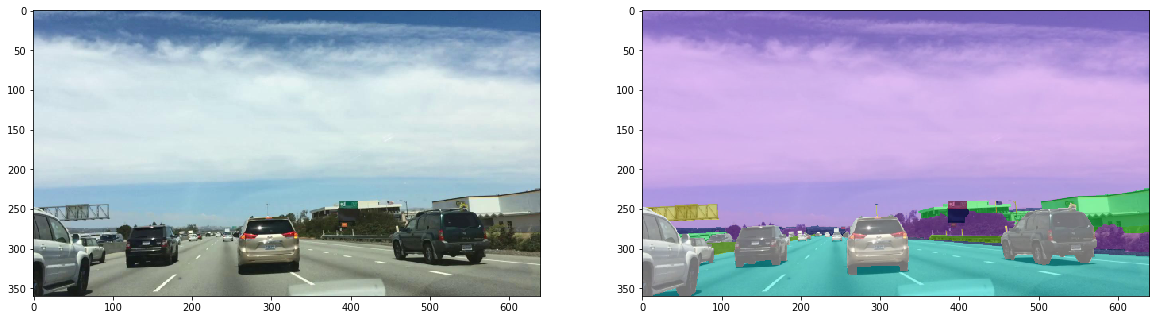

In [14]:
#Testing the train generator
print("An example of the training data generated by the training data generator:")
i = 0
image, label = next(train_generator)
image = image[i]
label = np.argmax(label[i], axis=-1)

fig=plt.figure(figsize=(20, 10))

cm = plt.get_cmap('gist_ncar')

fig.add_subplot(1, 2, 1)
plt.imshow(image * .5 + .5)
fig.add_subplot(1, 2, 2)
plt.imshow((image * .5 + .5) * .6 + cm(label/34.)[...,:3] * .4)
plt.show()

In [15]:
import keras.models as models
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.layers import Concatenate

<h1>Defining the Encoder And Decoder</h1><br>
This architecture has 4 encoders and 4 decoders. The decoders have max-pooling subsampling layers, and the encoders have their corresponding upsampling layers.

Later on we definitely plan on implementing the connections between the decoders and the encoders, so that the encoders receive the max-pooling indices as their input for better performance.

In [16]:
def create_encoding_layers(input_layer):
    kernel = 3
    filter_size = 64
    pool_size = 2
    
    x = Conv2D(filter_size, kernel, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)

    x = Conv2D(128, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)

    x = Conv2D(256, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)

    x = Conv2D(512, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x, residual_connections

In [17]:
def create_encoding_layers_residual(input_layer):
    kernel = 3
    filter_size = 64
    pool_size = 2
    residual_connections = []
    
    x = Conv2D(filter_size, kernel, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)
    residual_connections.append(x)

    x = Conv2D(128, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)
    residual_connections.append(x)

    x = Conv2D(256, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)
    residual_connections.append(x)


    x = Conv2D(512, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x, residual_connections

In [18]:
def create_decoding_layers(input_layer):
    kernel = 3
    filter_size = 64
    pool_size = 2

    x = Conv2D(512, kernel, padding='same')(input_layer)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(pool_size,pool_size))(x)
    x = Conv2D(256, kernel, padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(pool_size,pool_size))(x)
    x = Conv2D(128, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D(size=(pool_size,pool_size))(x)
    x = Conv2D(filter_size, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    
    return x

In [19]:
def create_decoding_layers_residual(input_layer, residual_connections):
    kernel = 3
    filter_size = 64
    pool_size = 2

    x = Conv2D(512, kernel, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Concatenate()([x, residual_connections[2]])

    x = UpSampling2D(size=(pool_size,pool_size))(x)
    x = Conv2D(256, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Concatenate()([x, residual_connections[1]])

    x = UpSampling2D(size=(pool_size,pool_size))(x)
    x = Conv2D(128, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Concatenate()([x, residual_connections[0]])
    
    x = UpSampling2D(size=(pool_size,pool_size))(x)
    x = Conv2D(filter_size, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    
    return x

In [20]:
#Defining the layers
input_layer = Input((*data_shape, 3))
encoded_layer, residual_conns = create_encoding_layers_residual(input_layer)
decoded_layer = create_decoding_layers_residual(encoded_layer, residual_conns)
final_layer = Conv2D(classes, 1, padding='same')(decoded_layer)
final_layer = Activation('softmax')(final_layer)

In [21]:
#Defining the model
semseg_model = Model(inputs=input_layer, outputs=final_layer)

In [22]:
#Compiling the model
semseg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [23]:
semseg_model.fit_generator(generator=train_generator,
                          steps_per_epoch=len(data_train) // batch_size,
                           epochs=1, validation_data=val_generator,
                           validation_steps=len(data_valid) // batch_size)

Epoch 1/1
17/17 [==============================] - 1699s 100s/step - loss: 1.9548 - acc: 0.5740 - val_loss: 5.7124 - val_acc: 0.3657


In [24]:
semseg_model.save_weights('trained_model_residual.h5')

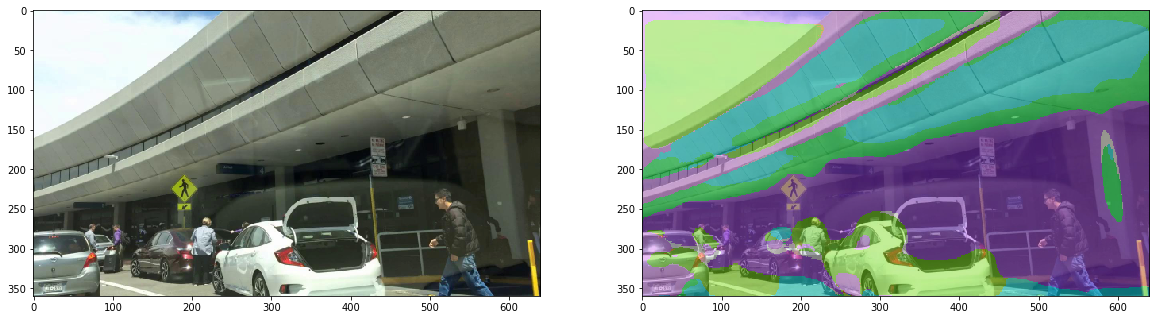

In [25]:
i = 0
image, label = next(val_generator)
#image = image[i]
#label = np.argmax(label[i], axis=-1)

pred = semseg_model.predict(image)
pred = np.argmax(pred[0], axis=-1)
fig=plt.figure(figsize=(20, 10))

cm = plt.get_cmap('gist_ncar')

fig.add_subplot(1, 2, 1)
plt.imshow(image[0] * .5 + .5)
fig.add_subplot(1, 2, 2)
plt.imshow((image[0] * .5 + .5) * .6 + cm(pred/34.)[...,:3] * .4)
plt.show()